In [21]:
from influxdb_client import InfluxDBClient
import pandas as pd
from utils.singleton import SingletonInstance

class InfluxConnector(metaclass=SingletonInstance):
    def __init__(self, url: str, token: str, org: str, bucket: str) -> None:
        self.client = InfluxDBClient(url=url, token=token, org=org)
        self.query_api = self.client.query_api()
        self.bucket = bucket

    def __create_query(self, tagnames: str | list[str], start: str, end: str):
        if isinstance(tagnames, str):
            tagnames = [tagnames]
        tag_conditions = " or ".join([f'r["tagName"] == "{tagname}"' for tagname in tagnames])
        query = f'''
            from(bucket: "{self.bucket}")
            |> range(start: {start}, stop: {end})
            |> filter(fn: (r) => {tag_conditions})
            |> keep(columns: ["_time", "_value", "tagName"])
        '''
        return query

    def __parse_influx_res(self, tables) -> pd.DataFrame:
        records = []
        for table in tables:
            for record in table.records:
                records.append({
                    "_time": record.get_time(),
                    "_value": record.get_value(),
                    "tagName": record.values.get("tagName")
                })
        if not records:
            return pd.DataFrame()
        df = pd.DataFrame(records)
        return df

    def load_from_influx(self, tagnames: str | list[str], start: str, end: str) -> pd.DataFrame:
        query = self.__create_query(tagnames, start, end)
        tables = self.query_api.query(query)
        df = self.__parse_influx_res(tables)
        if not df.empty:
            df['_time'] = pd.to_datetime(df['_time'], utc=True)
            df['_time'] = df['_time'].dt.tz_convert('Asia/Seoul')
            df.set_index('_time', inplace=True)
            # 태그별로 데이터를 분리하여 처리
            dfs = []
            for tagname in tagnames:
                tag_df = df[df['tagName'] == tagname].resample('5S').first().dropna().reset_index()
                dfs.append(tag_df)
            if dfs:
                resampled_df = pd.concat(dfs, axis=0)
                return resampled_df
        return pd.DataFrame()

# # 사용 예시
# url = "http://localhost:8086"
# token = "TwrNN4J0ablMZFPFRB9GsUahs-uESVsM6WU0KKtY-jvJrFbhnxt7atnPg2wyU801B2GbFprJtomq5N1jog9uAg=="
# org = "gaonpf"
# bucket = "thermal_data"
# tagname = ["1"]

#test
url = "http://localhost:8086"
token = "TwrNN4J0ablMZFPFRB9GsUahs-uESVsM6WU0KKtY-jvJrFbhnxt7atnPg2wyU801B2GbFprJtomq5N1jog9uAg=="

# 사용 예시
# url = "http://192.168.10.60:8086"
# token = "tzxpkRANOkRZsCxEDEDyxKHNFTzt6pIQYJcJY5o_9wCM0QNaTfxuKWstSYMzZnCe7lBTv0Ai7flewVI4CuqILA=="
org = "gaonpf"
bucket = "thermal_data"
tagname = ["1", "2", "3"]

connector = InfluxConnector(url=url, token=token, org=org, bucket=bucket)
df = connector.load_from_influx(tagnames=tagname, start="2024-08-12T05:10:00Z", end="now()")
print(df.tail(10))

                        _time     _value tagName
221 2024-08-12 14:28:25+09:00  36.142724       2
222 2024-08-12 14:28:30+09:00  37.729508       2
223 2024-08-12 14:28:35+09:00  37.958287       2
224 2024-08-12 14:28:40+09:00  37.561761       2
225 2024-08-12 14:28:45+09:00  37.995114       2
226 2024-08-12 14:28:50+09:00  36.317251       2
227 2024-08-12 14:28:55+09:00  37.170183       2
228 2024-08-12 14:29:00+09:00  36.250505       2
229 2024-08-12 14:29:05+09:00  37.032463       2
230 2024-08-12 14:29:10+09:00  36.958215       2


In [22]:
test_df = list(df[df['tagName']=='1']['_value'])

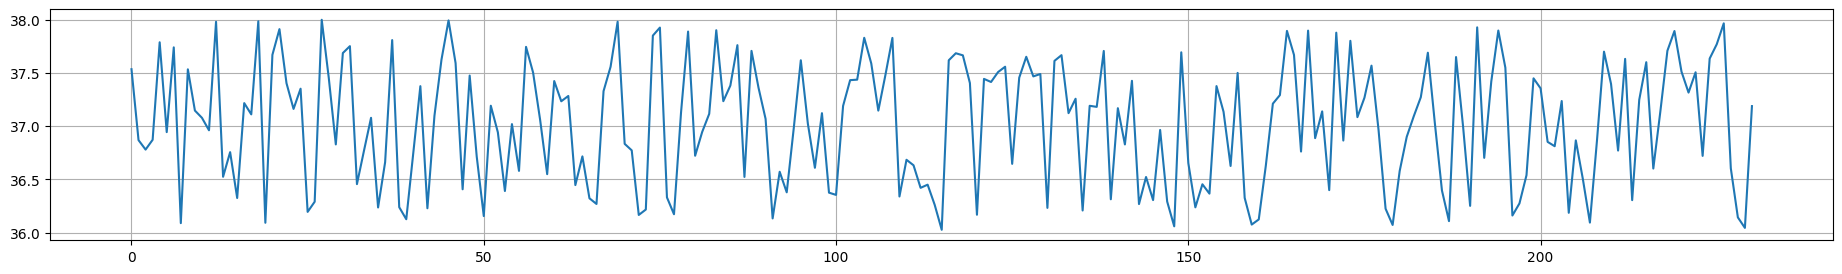

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(23,3))
plt.plot(test_df)
plt.grid()
plt.show()

In [24]:
import itertools

p = range(0,3)
d = range(0,3)
q = range(0,3)
pdq = list(itertools.product(p, d,q))

aic = []
for i in pdq:
    model = ARIMA(test_df, order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
    
# Search optimal parameters
optimal = [(pdq[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

ARIMA: (0, 0, 0) >> AIC : 401.41
ARIMA: (0, 0, 1) >> AIC : 398.81
ARIMA: (0, 0, 2) >> AIC : 400.7
ARIMA: (0, 1, 0) >> AIC : 524.39
ARIMA: (0, 1, 1) >> AIC : 406.13
ARIMA: (0, 1, 2) >> AIC : 403.28
ARIMA: (0, 2, 0) >> AIC : 757.19
ARIMA: (0, 2, 1) >> AIC : 530.55


c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (0, 2, 2) >> AIC : 420.53
ARIMA: (1, 0, 0) >> AIC : 399.2
ARIMA: (1, 0, 1) >> AIC : 400.76


c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (1, 0, 2) >> AIC : 396.79
ARIMA: (1, 1, 0) >> AIC : 486.69
ARIMA: (1, 1, 1) >> AIC : 403.64
ARIMA: (1, 1, 2) >> AIC : 405.24
ARIMA: (1, 2, 0) >> AIC : 653.33
ARIMA: (1, 2, 1) >> AIC : 493.69


c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (1, 2, 2) >> AIC : 417.44
ARIMA: (2, 0, 0) >> AIC : 400.37


c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA: (2, 0, 1) >> AIC : 396.86


c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\jhpark\anaconda3\envs\server\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA: (2, 0, 2) >> AIC : 398.75
ARIMA: (2, 1, 0) >> AIC : 467.53
ARIMA: (2, 1, 1) >> AIC : 404.93
ARIMA: (2, 1, 2) >> AIC : 406.77
ARIMA: (2, 2, 0) >> AIC : 605.94
ARIMA: (2, 2, 1) >> AIC : 475.13
ARIMA: (2, 2, 2) >> AIC : 497.69


[((1, 0, 2), 396.79)]

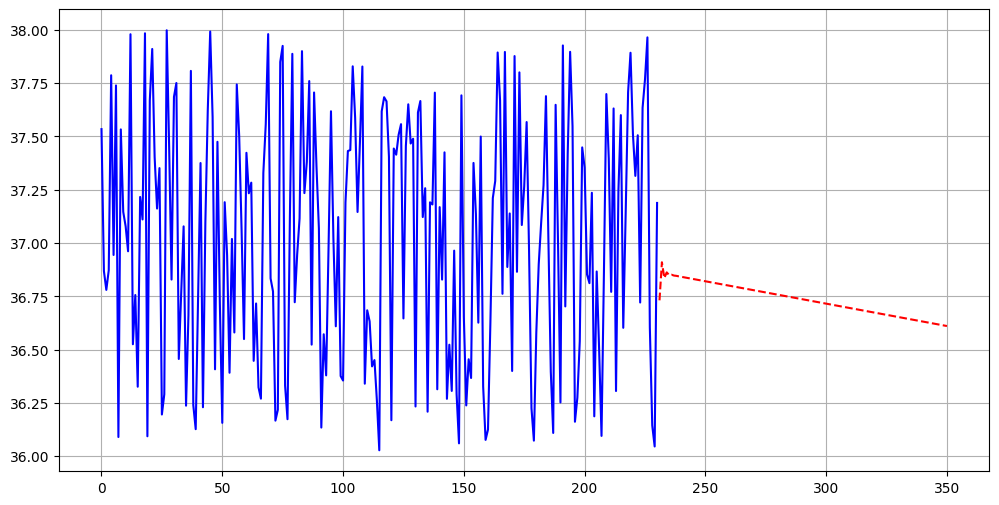

In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 학습
model = ARIMA(test_df, order=(1,2,1))
model_fit = model.fit()

# 예측 기간 설정 (다음 50 스텝 예측)
forecast_steps = 120
forecast = model_fit.forecast(steps=forecast_steps)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_df)), test_df, label='Observed Temperature', color='blue')
plt.plot(range(len(test_df), len(test_df) + forecast_steps), forecast, label='Forecasted Temperature', color='red', linestyle='--')
plt.grid()
plt.show()
